# Proyecto 2
### Inteligencia Artificial
José Daniel Gómez Cabrera 21429

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [147]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dellg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dellg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dellg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dellg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dellg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [148]:
# WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()
# Porter Stemmer
stemmer = PorterStemmer()
# Tokenizer
tokenizer = WhitespaceTokenizer()
# stopwords queue
stop_words = set(stopwords.words('english'))

Read file with codification

In [149]:
spam = pd.read_csv('spam.csv', encoding='ISO-8859-1')
spam = spam[['v1', 'v2']]

Mapping the POS

In [150]:
# Map POS tag to the first character lemmatize() accepts
def get_wordnet_pos(word, tag):
  tag_dict = {
    'J': wordnet.ADJ,
    'N': wordnet.NOUN,
    'V': wordnet.VERB,
    'R': wordnet.ADV
  }
  return tag_dict.get(tag[0].upper(), wordnet.NOUN)

#### EDA
Spam & ham

In [151]:
spam['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

Train & test set

In [152]:
train, test = train_test_split(
  spam.copy(),
  test_size=0.20,
  stratify=spam['v1'],
  random_state=42
)

In [153]:
train['v1'].value_counts()

ham     3859
spam     598
Name: v1, dtype: int64

In [154]:
test['v1'].value_counts()

ham     966
spam    149
Name: v1, dtype: int64

##### Data cleaning

In [155]:
# Lower cases
def toLower(texts):
  return [text.lower() for text in texts]

# Tokenization
def tokenization(texts):
  return [word_tokenize(text) for text in texts]

# Punctuation marks removal
def marksRemoval(texts):
  return [[token for token in text if not re.search(r'\W+', token)] for text in texts]

# number tokens removal
def numTokensRemoval(texts):
  return [[token for token in text if not re.search(r'[0-9]+', token)] for text in texts]

# stopwords removal
def stopwordsRemoval(texts):
  return [[token for token in text if token not in stop_words] for text in texts]

# Lemmatization
def lemmatizater(texts):
  values = [nltk.pos_tag(text) for text in texts]
  return [[lemmatizer.lemmatize(item[0], get_wordnet_pos(item[0], item[1])) for item in value] for value in values]

# stemming
def stemmazer(texts):
  return  [[stemmer.stem(token) for token in text] for text in texts]

##### Model

In [156]:
def processor(texts):
  modelFunctions = [
    toLower,
    tokenization,
    marksRemoval,
    numTokensRemoval,
    stopwordsRemoval,
    lemmatizater,
    stemmazer
  ]

  for func in modelFunctions:
    texts = func(texts)

  return texts

In [157]:
v2 = processor(train['v2'].tolist())
train['v2'] = v2

Dictionary instances

In [158]:
hams = {}
spams = {}

# words counter for each category
def wordCounter(words, wordsDict):
  for word in words:
    if word in wordsDict:
      wordsDict[word] += 1
    else:
      wordsDict[word] = 1

# Update dicts by categories
for _, row in train.iterrows():
  if row['v1'] == 'ham':
    wordCounter(row['v2'], hams)
  elif row['v1'] == 'spam':
    wordCounter(row['v2'], spams)

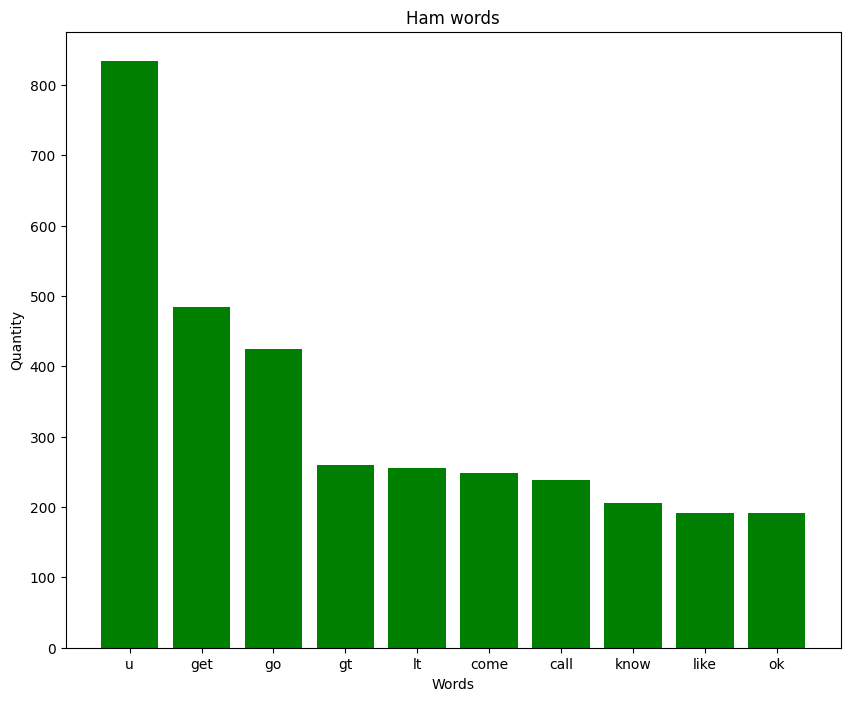

In [159]:
sortedHams = sorted(hams.items(), key=lambda item: item[1], reverse=True)[:10]
words, counts = zip(*sortedHams) # unzip tuples
plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='green')
plt.title('Ham words')
plt.xlabel('Words')
plt.ylabel('Quantity')
plt.xticks(rotation=0)
plt.show()

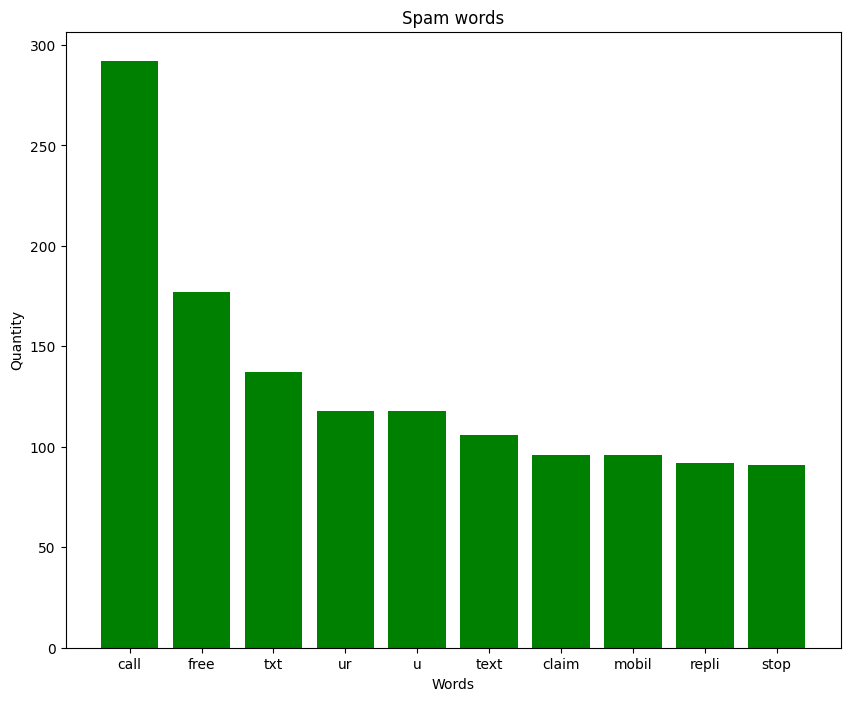

In [160]:
sortedSpams = sorted(spams.items(), key=lambda item: item[1], reverse=True)[:10]
words, counts = zip(*sortedSpams)  # unzip tuples

plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='green')
plt.title('Spam words')
plt.xlabel('Words')
plt.ylabel('Quantity')
plt.xticks(rotation=0)
plt.show()

Probabilities

In [161]:
h, s = train['v1'].value_counts().tolist()
total = h + s

# P(S)
h_probability = h / total
# P(H)
s_probability = s / total

spamWords = sum(spams.values())
hamWords = sum(hams.values())

# P(S|W)
def s_given_w_probability(word):
  w_given_s_prob = spams[word] / spamWords # P(W|S)
  w_given_h_prob = hams[word] / hamWords # P(W|H)
  numerator = w_given_s_prob * s_probability # P(W|S) * P(S)
  divider = numerator + (w_given_h_prob * h_probability) # [P(W|S) * P(S)] + [P(W|H) * P(H)]

  if divider == 0:
    return 0

  return numerator / divider

##### Spam probability

Prediction model

In [162]:
def predModel(probs):
  numerator = 1
  divider = 1

  for prob in probs:
    numerator*=prob
    divider*=(1-prob)

  divider = numerator + divider

  if divider == 0:
    return 0

  return numerator / divider

Words filter

In [163]:
def wordsFilter(text):
  return [word for word in text if word in spams and word in hams]

Text predictor

In [172]:
def predictor(text,result):
  text = wordsFilter(text)
  decimals = 4

  if len(set(text))>0:
    probs = [s_given_w_probability(word) for word in text]
    res = ""

    for i in range(len(text)):
      res+=text[i]+" -> "+str(round(probs[i],decimals))+","

    result["Recognized words"] = res[:-1]
    total = predModel(probs)

    result ["Spam probability"] = str(round(total,decimals))

    res += "Prediction -> "
    if total>0.5:
      result["Prediction"] = "spam"
    else:
      result["Prediction"] = "ham"
  else:
    result["Recognized words"] = "Words not recognized :("

  return result


Performance tests

In [165]:
def prediction(category,text):
  result = dict()
  result["Category"] = category
  result["Text"] = text
  test_text = processor([text])[0]
  result = predictor(test_text,result)

  return result


In [166]:
test_values = []
pred_values = []

for _, row in test.iterrows():
  
  result = prediction(row['v1'],row['v2'])

  if "Prediction" in result:
    test_values.append(result["Category"])
    pred_values.append(result["Prediction"])

  print(result)

{'Category': 'ham', 'Text': "Oh right, ok. I'll make sure that i do loads of work during the day!  got a really nasty cough today and is dry n shot so that should really help it!", 'Recognized words': 'oh : 0.007,right : 0.0162,make : 0.0436,load : 0.0633,work : 0.0126,day : 0.099,get : 0.083,today : 0.1644,n : 0.042,shot : 0.3782,help : 0.1906', 'Spam probability': '0.0', 'Prediction': 'ham'}
{'Category': 'ham', 'Text': 'I am in tirupur.  call you da.', 'Recognized words': 'call : 0.4263', 'Spam probability': '0.4263', 'Prediction': 'ham'}
{'Category': 'ham', 'Text': 'No that just means you have a fat head', 'Recognized words': 'Words not recognized :('}
{'Category': 'spam', 'Text': 'You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327', 'Recognized words': 'cash : 0.7126', 'Spam probability': '0.7126', 'Prediction': 'spam'}
{'Category': 'ham', 'Text': 'Come aftr  &lt;DECIMAL&gt; ..now i m cleaning the house', 'Recognized words': 'come : 0.0144,hous : 0.0258', 'Spam p

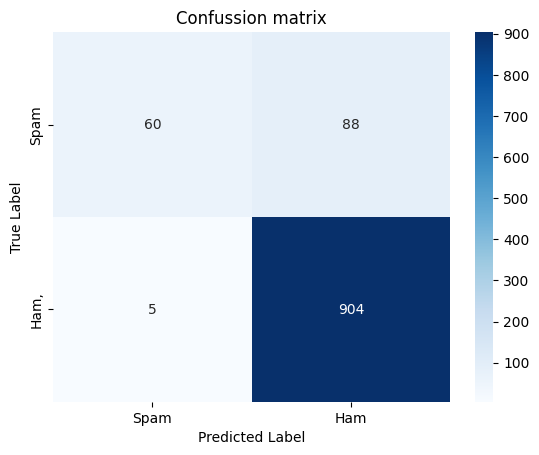

In [167]:
confMatrix = confusion_matrix(test_values, pred_values,labels=["spam","ham"])
sb.heatmap(
  confMatrix,
  annot=True,
  cmap="Blues",
  fmt="d",
  xticklabels=['Spam', 'Ham',],
  yticklabels=['Spam', 'Ham,']
)
plt.title('Confussion matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [168]:
print("\n---- Classification Report ----\n")
print(classification_report(test_values, pred_values))


---- Classification Report ----

              precision    recall  f1-score   support

         ham       0.91      0.99      0.95       909
        spam       0.92      0.41      0.56       148

    accuracy                           0.91      1057
   macro avg       0.92      0.70      0.76      1057
weighted avg       0.91      0.91      0.90      1057



Program

In [178]:
category  = input("Category message >>")
message  = input("Message >>")

print("\n------- Prediction -------\n")

myPrediction = prediction(category,message)
for key in myPrediction:
  if key == "Recognized words":
    print(f"{key}")
    for word in myPrediction[key].split(","):
      print(f"  - {word}")
  else:
    print(f"{key}: {myPrediction[key]}")

print("\n--------------------------")


------- Prediction -------

Category: spam
Text: hello! i want my money or die!!! >:(
Recognized words
  - hello : 0.0707
  - want : 0.0808
  - money : 0.0482
  - die : 0.0416
Spam probability: 0.0
Prediction: ham

--------------------------
